In [2]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats import ttest_ind
import scipy.stats as stats

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [4]:
def generate_plots(hue='none'):
    for i in plot_list:
        if(hue=='none'):
            ax = sns.factorplot(data = enrollments_quarterly_df, x = 'quarter', y = i, kind = 'bar', size = 6, order=order_list)
            ax.set(xlabel='Quarter', ylabel=i, title = (i + '_overall'))
        elif(hue=='agg'):
            ax = sns.pointplot(data=enrollments_quarterly_df.groupby('quarter').sum().reset_index(), x='quarter', y=i)
            ax.set(xlabel='Quarter', ylabel=i, title = (i + '_' + hue))
        else:
            ax = sns.factorplot(data = enrollments_quarterly_df, x = 'quarter', y = i, kind = 'bar', size = 6, order=order_list, hue=hue)
            ax.set(xlabel='Quarter', ylabel=i, title = (i + '_' + hue))

In [5]:
def run_stats(metric, test, pair=[1,2]):
    
    if (metric == 'enrolls'):
        metric = 'num_enrolls'
    elif (metric == 'verifs'):
        metric = 'num_verifs'
    else:
        metric = 'vtr'
  
    q1_16 = enrollments_quarterly_df[enrollments_quarterly_df.quarter=='2016_Q1'][metric]
    q2_16 = enrollments_quarterly_df[enrollments_quarterly_df.quarter=='2016_Q2'][metric]
    q3_16 = enrollments_quarterly_df[enrollments_quarterly_df.quarter=='2016_Q3'][metric]
    q4_16 = enrollments_quarterly_df[enrollments_quarterly_df.quarter=='2016_Q4'][metric]
    q1_17 = enrollments_quarterly_df[enrollments_quarterly_df.quarter=='2017_Q1'][metric]
    
    df_array = [q1_16, q2_16, q3_16, q4_16, q1_17]
    
    if (test == 't'):
        return ttest_ind(df_array[pair[0]], df_array[pair[1]])
    else:    
        return stats.f_oneway(q1_16, q2_16, q3_16, q4_16, q1_17)

# Queries
* * *
### Pull all enrollment data for the past 5Q
### Attributing a course to a quarter based on the end date of the course

In [6]:
enrollments_quarterly = """

select 
CASE 
WHEN d.enddate BETWEEN '2016-07-01' AND '2016-10-01' THEN '2017_Q1'
WHEN d.enddate BETWEEN '2016-04-01' AND '2016-07-01' THEN '2016_Q4'
WHEN d.enddate BETWEEN '2016-01-01' AND '2016-04-01' THEN '2016_Q3'
WHEN d.enddate BETWEEN '2015-10-01' AND '2016-01-01' THEN '2016_Q2'
WHEN d.enddate BETWEEN '2015-07-01' AND '2015-10-01' THEN '2016_Q1'
ELSE NULL
END AS quarter,
a.course_id,
b.pacing_type,
b.level_type,
c.program_type,
COUNT(1) AS num_enrolls,
SUM(CASE WHEN 
a.first_verified_enrollment_time IS NOT NULL 
AND a.first_enrollment_time < b.end_time 
AND a.first_enrollment_time < e.course_seat_upgrade_deadline
THEN 1 ELSE 0 END) as num_verifs
from
production.d_user_course a
LEFT JOIN
production.d_course b
ON a.course_id = b.course_id
LEFT JOIN
production.d_program_course c
ON a.course_id = c.course_id
LEFT JOIN
ed_services.CourseCatalog_20161017 d
ON a.course_id = d.CourseID
LEFT JOIN
production.d_course_seat e
ON a.course_id = e.course_id
WHERE 
d.enddate BETWEEN '2015-07-01' AND '2016-10-01'
AND e.course_seat_type = 'verified'
GROUP BY 1,2,3,4,5
"""

In [7]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')
cur.execute(enrollments_quarterly)
extract = cur.fetchall()
enrollments_quarterly_df = pd.DataFrame(extract)

connection.close()

In [8]:
enrollments_quarterly_df.head()
enrollments_quarterly_df['is_microsoft'] = enrollments_quarterly_df.course_id.str.contains('Microsoft')
enrollments_quarterly_df['vtr'] = enrollments_quarterly_df.num_verifs*100.0/enrollments_quarterly_df.num_enrolls

In [9]:
plot_list = [
'num_enrolls',
'num_verifs',
'vtr'  
]
order_list = ['2016_Q1', '2016_Q2', '2016_Q3', '2016_Q4', '2017_Q1']

# Overall Perf
#### Note on how to read these plots: bar height represents mean, ends of the black line represent the 5th and 95th percentile confidence interval. 
#### In general, overlapping confidence intervals = not a statisically significant difference
* * *

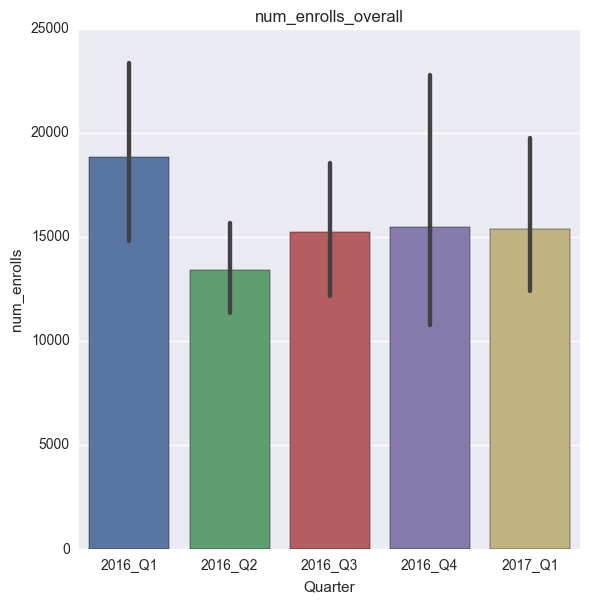

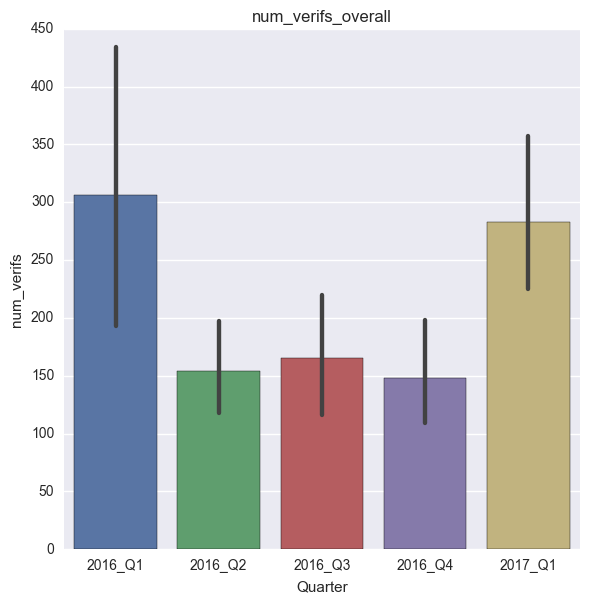

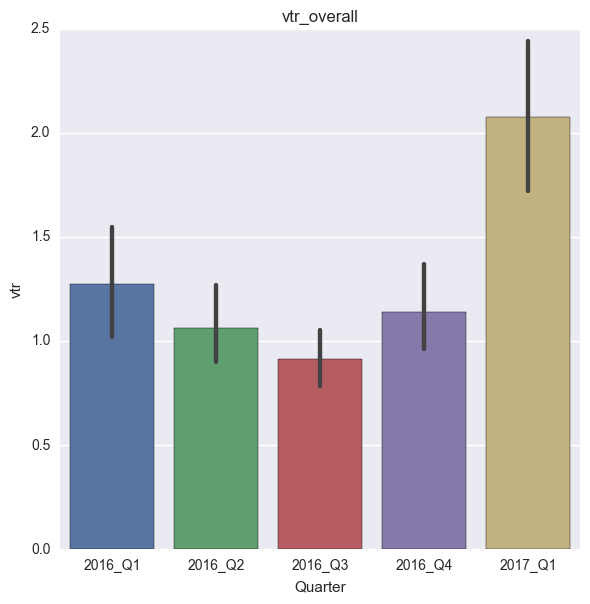

In [305]:
generate_plots()

## Only clear significance is in VTR increase in 2017 Q1.
## Run a quick one-way ANOVA to verify...

In [306]:
run_stats('enrolls', 'anova')

F_onewayResult(statistic=0.43625204314428451, pvalue=0.78247764688058796)

In [307]:
run_stats('verifs', 'anova')

F_onewayResult(statistic=5.5348499164307281, pvalue=0.00021230620652513301)

In [308]:
print run_stats('verifs', 't', [0,1])
print run_stats('verifs', 't', [1,4])

Ttest_indResult(statistic=2.8650914635639362, pvalue=0.0044858889512847935)
Ttest_indResult(statistic=-3.3467779804795743, pvalue=0.00090714041929200581)


#### Just kidding, Q2 2016 is low for verifications compared with Q1 2016 and Q1 2017

In [309]:
run_stats('vtr', 'anova')

F_onewayResult(statistic=13.350924287048471, pvalue=1.5111580538054986e-10)

* * *
# Split by Microsoft
### Are Microsoft courses performing disproportionately better than other course offerings?
* * *

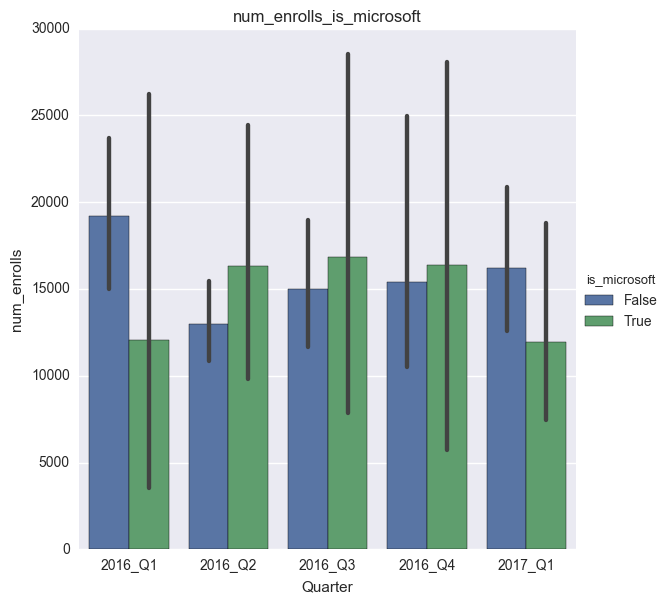

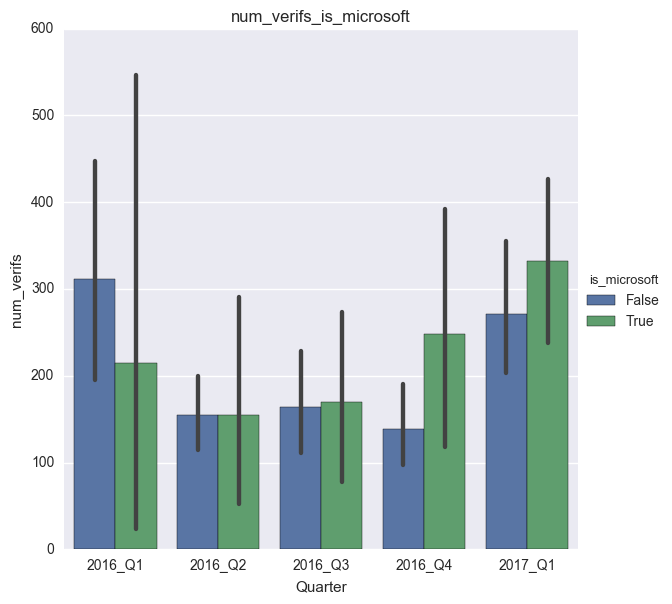

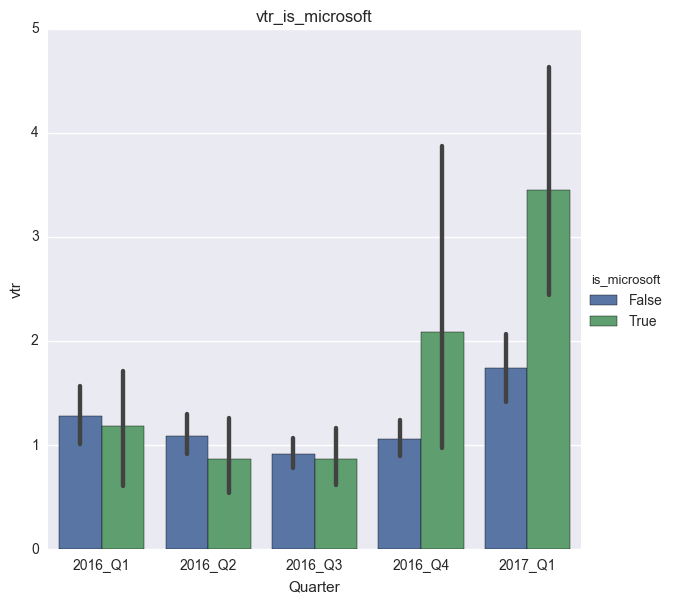

In [310]:
generate_plots('is_microsoft')

# Microsoft courses have better VTR, but in general perform equally with the rest of our offerings.

* * *
# Split by Pacing Type
### Is there a difference in key metrics across self serve vs instructor led?
* * *

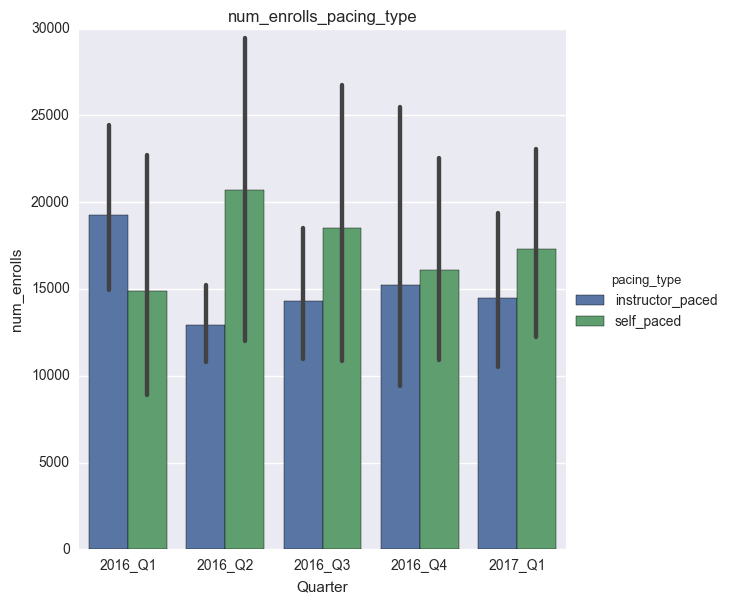

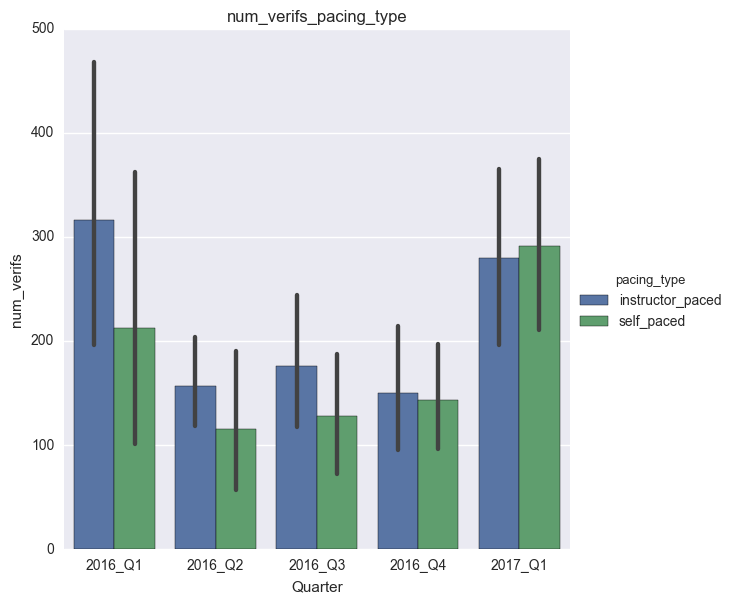

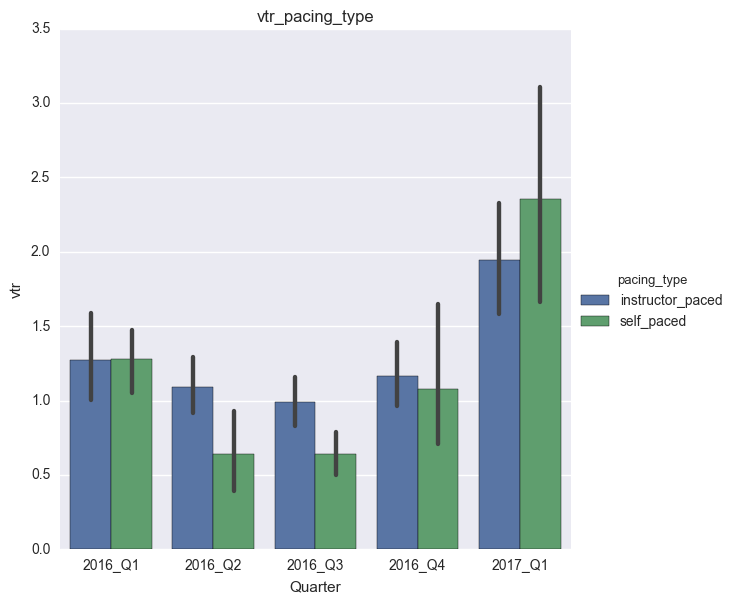

In [311]:
generate_plots('pacing_type')

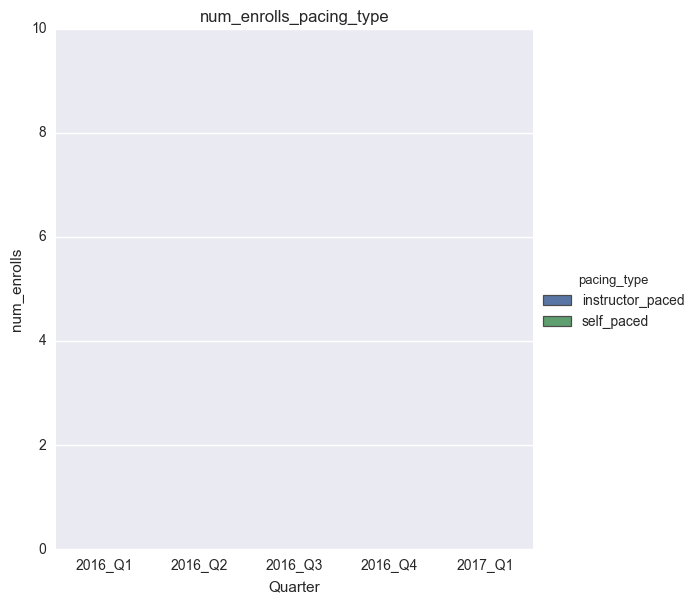

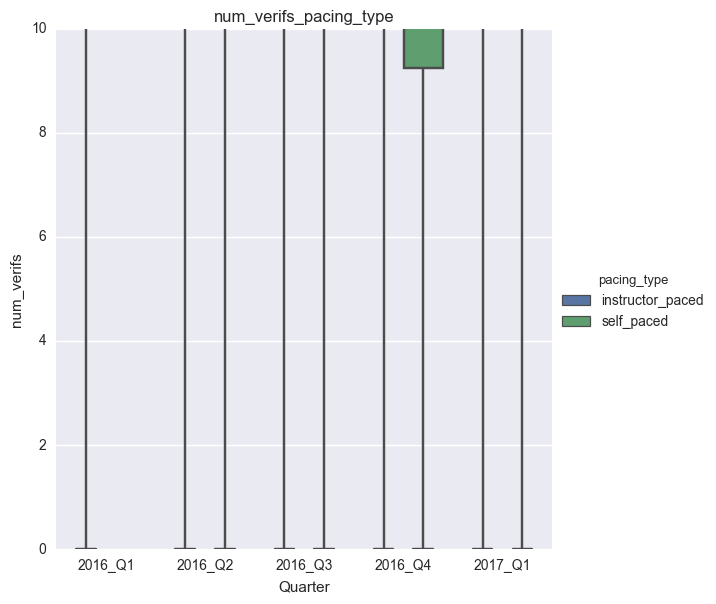

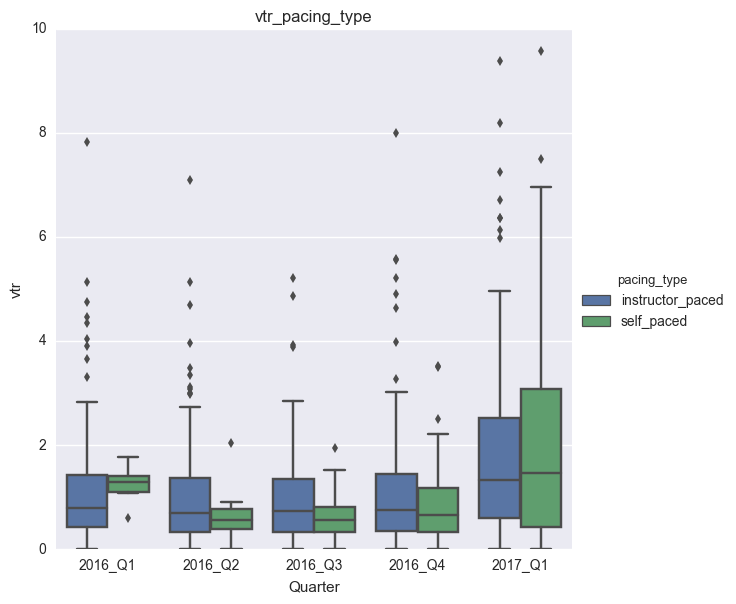

In [11]:
for i in plot_list:
    hue = 'pacing_type'
    ax = sns.factorplot(data = enrollments_quarterly_df, x = 'quarter', y = i, kind = 'box', size = 6, order=order_list, hue=hue)
    ax.set(xlabel='Quarter', ylabel=i, title = (i + '_' + hue), ylim=(0,10))

# With the exception of Q2 2016, enrollments/verifications/vtr are statistically different when comparing self paced vs instructor paced courses

* * *
# Split by Course Level
### What types of courses are people enrolling in more?
* * *

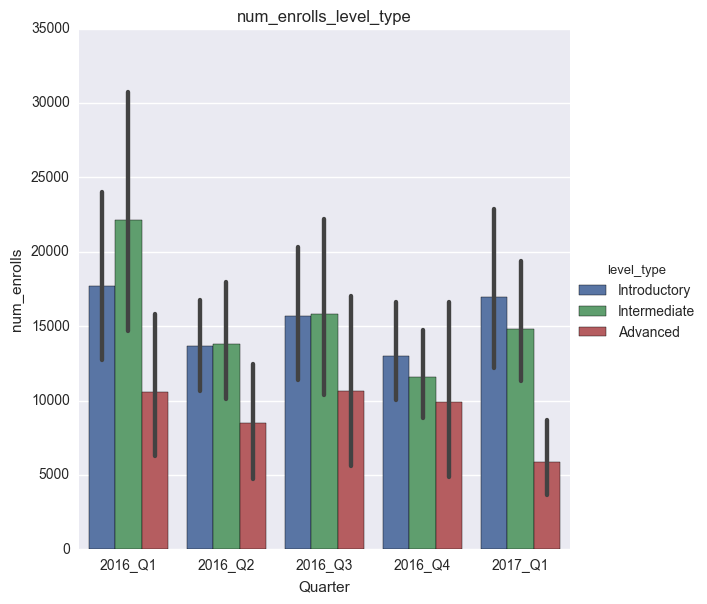

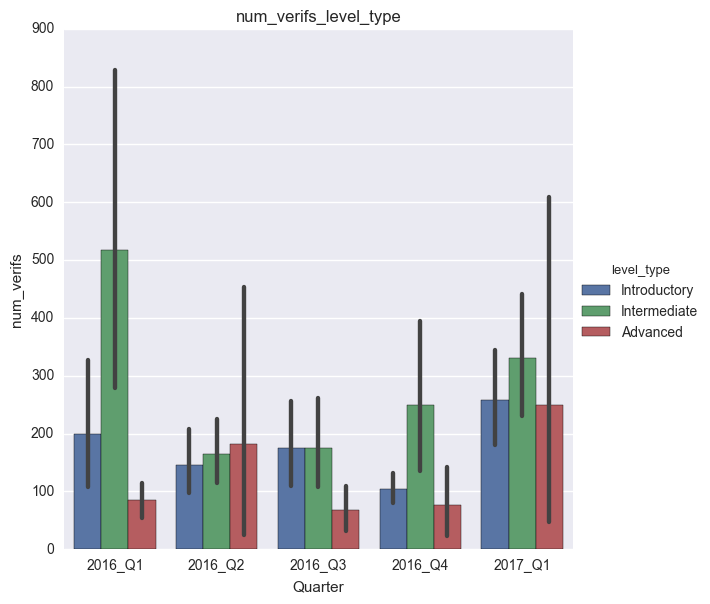

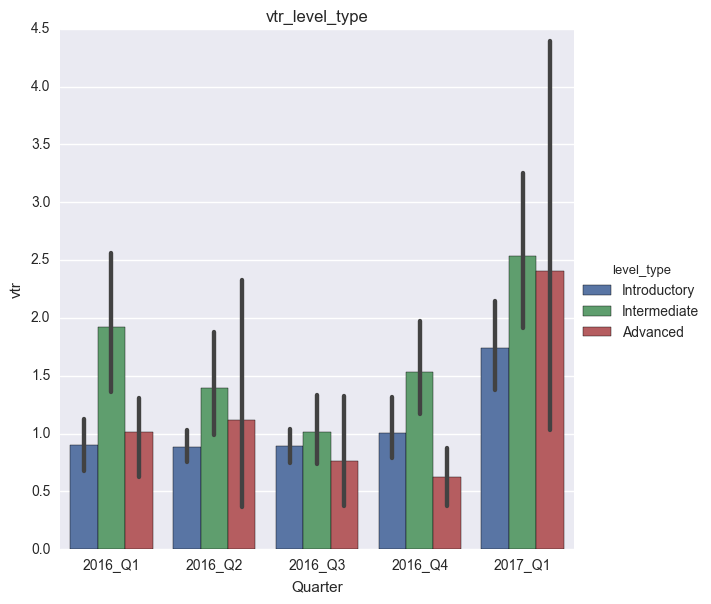

In [312]:
generate_plots('level_type')